# Assigment 1, part I
Please consider a wind farm with the nominal (installed) capacity of 150 MW. We are interested to formulate and solve an offering strategy problem for this farm. This problem determines her participation strategy in the day‐ahead market (in terms of her hourly production quantities). Note
that her offer price is zero. We consider a time framework of 24 hours. Please also note that we
discard reserve and intra‐day markets, and consider day‐ahead and balancing markets only.\
\
**Scenarios:** 
- Please consider at least 50 scenarios. We can assume these scenarios are equiprobable.
- **Note 1:** the two sources of uncertainty are wind power forecast and day‐ahead market price forecast. Discarding the potential correlation between these two sources of uncertainty, the total number of scenarios is equal to the number of scenarios for uncertain source 1 times the number of scenarios for uncertain source 2. For example, if we consider 10 wind power forecast scenarios and 5 day‐ahead price forecast scenarios, this results in 5*10 = 50 scenarios.
- **Note 2:** Similar to the lecture, the coefficients for the balancing price are 0.9 and 1.2.\

**Example:**
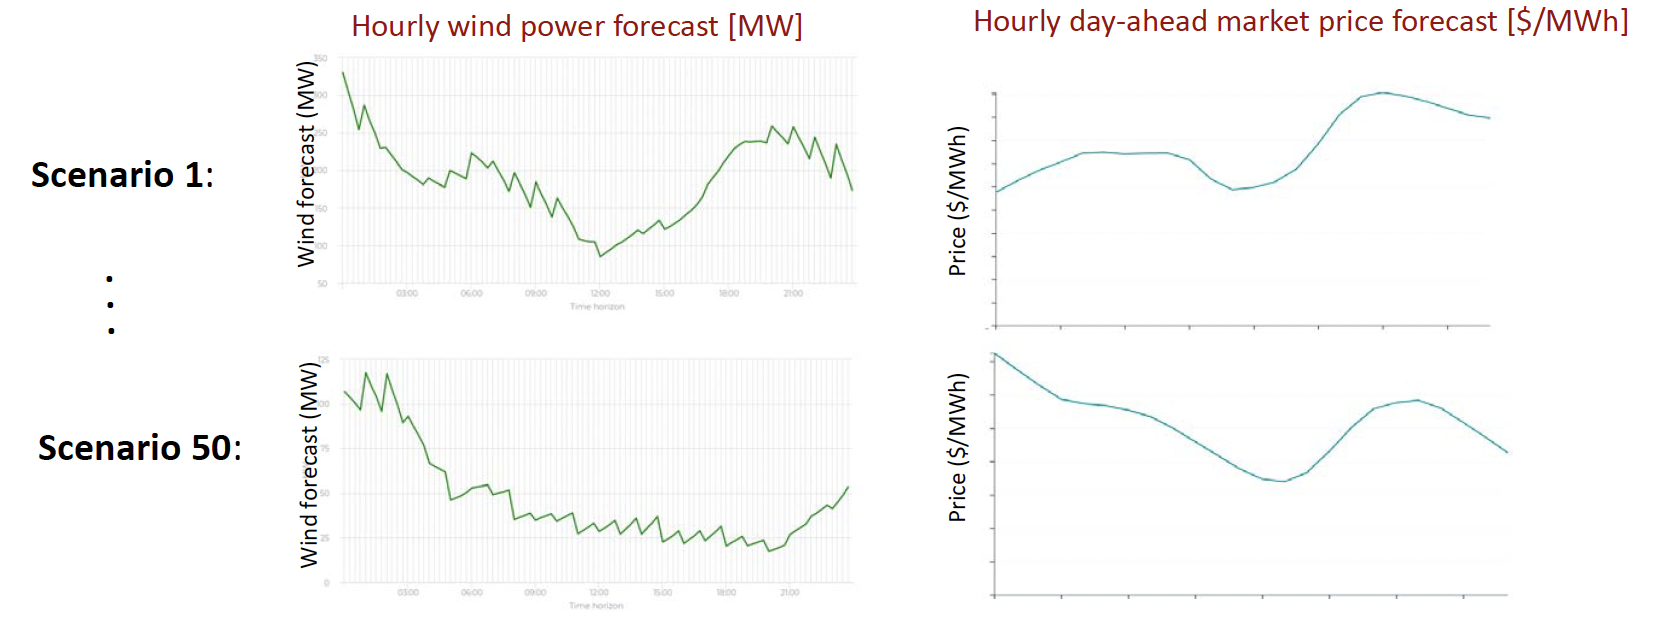

**Potential references for wind power scenarios:**
- **Reference 1:** https://sites.google.com/site/datasmopf/wind‐scenarios
- **Reference 2:** You can get wind data from FINGERID website(https://www.fingrid.fi/en/electricitymarket/electricity‐market‐information/wind‐power‐generation/) or ELIA website (https://www.elia.be/en/griddata/power‐generation/wind‐power‐generation), and normalize them for a 150‐MW wind farm. Although they report “aggregate” wind data, you can assume they are data for an individual farm. The wind profile during a day can be seen as a scenario. For example, wind profile on March 1 can be seen as scenario 1. This profile on March 2 can be seen as the second scenario, and so on.

**Potential reference for day‐ahead market price scenarios:**
- Using a similar strategy, you can generate price scenarios from Nord Pool website: https://www.nordpoolgroup.com/Market‐data1/Dayahead/Area‐Prices/ALL1/Hourly/?view=table For example, you can assume the wind farm is located in DK1, and use the corresponding hourly day‐aheadmarket prices.

**Steps:**
1. Formulate and solve the stochastic offering strategy problem accounting for 50 scenarios. Determine the optimal hourly production quantities that the wind farm should offer in the day‐ahead market. Report the expected profit.
2. While keeping the coefficient for the balancing market price under power excess condition to 0.9, vary the other coefficient from 1.05 to 1.35, and explore how the offerings strategy of the wind farm changes. Similarly, keep coefficient 1.2 unchanged, and vary the other one from 0.75 to 0.95. These results can be illustrated through a couple of figures. A discussion on results is recommended.
3. For fixed coefficients of 0.9 and 1.2 and given value of $\alpha = 0.90$, formulate and solve the riskaverse offering strategy problem. Recall that the objective function is in the form of $ [(expected \ profit)
+ (\beta * CVaR)]$.\
Gradually increase the value of $\beta$, starting from zero. For each value of $\beta$, save the values obtained for the expected profit and for the CVaR, and plot a 2‐dimention figure ($expected profit$ versus $CVaR$). Note that the $CVaR$ value does not include $\beta$. Please interpret this figure. In addition, please explain how the offering strategy of the wind farm and her profit volatility over scenarios are changing by increasing $\beta$. Finally, for different values of confidence level (i.e., \alpha=0.80 and \alpha=0.95), repeat this step and report your observations.

# 0. Get data from reference

In [9]:
Pⁿᵒᵐ = 150 # nominal installed capacity 
N_t = 24; # time framework of 24 hors

## 1.1 Reference for wind power scenarios

┌ Warning: thread = 1 warning: only found 1 / 101 columns around data row: 44. Filling remaining columns with `missing`
└ @ CSV /Users/diegopisera/.julia/packages/CSV/0Elut/src/file.jl:577


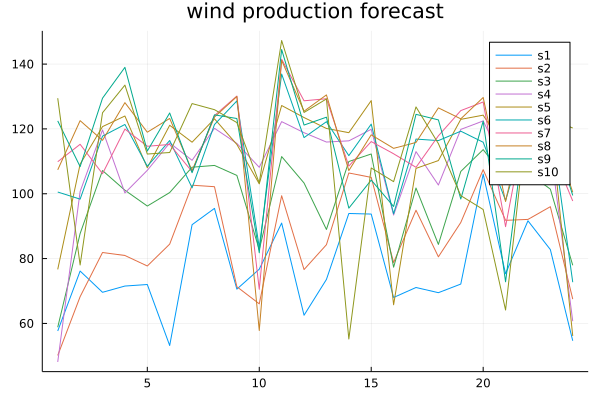

In [13]:
using CSV

Pₚᵤ = zeros(24,10)
N_data_pʳᵉᵃˡ = 10

file = CSV.File(open("scen_zone1.csv");header=false, skipto=2, drop=[1]);

#a = collect(1:4:93)
#b = collect(1:2:44)
for i in 1:N_data_pʳᵉᵃˡ
    for t in 1:N_t
    Pₚᵤ[t,i] = file[i][t] 
    end
end

using Plots

data_pʳᵉᵃˡ = Pⁿᵒᵐ * Pₚᵤ
x = 1:N_t
plot(x, data_pʳᵉᵃˡ, title = "wind production forecast", label = ["s1" "s2" "s3" "s4" "s5" "s6" "s7" "s8" "s9" "s10"])

## 1.2 Reference for day‐ahead market price scenarios

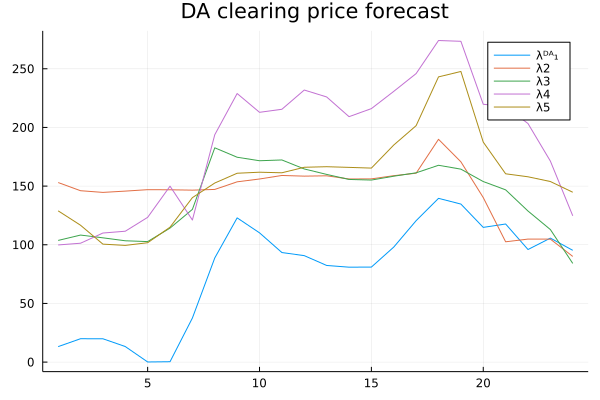

In [22]:
using CSV

N_data_λᴰᴬ = 5
data_λᴰᴬ = zeros(24,5);

for i in 1:N_data_λᴰᴬ   
    file = CSV.File(open("Assigment2_data/Day-ahead prices-"*string.(i)*".csv");header=false, skipto=2, drop=[1])
    for t in 1:N_t
        data_λᴰᴬ[t,i] = parse(Float64, file[1+t][1])
    end
    
end

using Plots

x = 1:24
plot(x, data_λᴰᴬ, title = "DA clearing price forecast", label = ["λᴰᴬ₁" "λ2" "λ3" "λ4" "λ5"])

## 1. Formulate and solve the stochastic offering strategy problem
Formulate and solve the stochastic offering strategy problem accounting for 50 scenarios. Determine the optimal hourly production quantities that the wind farm should offer in the day‐ahead market. Report the expected profit.

In [15]:
## Input
N_ω = N_pʳᵉᵃˡ * N_λᴰᴬ # numbers of scenarios
pʳᵉᵃˡ = repeat(data_pʳᵉᵃˡ,1,5)
λᴰᴬ = repeat(data_λᴰᴬ, inner = (1,10))

ℼ = ones(50) / 50;

In [16]:
## Resolution 
using JuMP
using GLPK

# Optimization problem
OSP_model = Model(GLPK.Optimizer)

@variable(OSP_model, pᴰᴬ[1:N_t])
@variable(OSP_model, Δ[1:N_t,1:N_ω])
@variable(OSP_model, Δ_up[1:N_t,1:N_ω] >= 0)
@variable(OSP_model, Δ_down[1:N_t,1:N_ω] >= 0)

@constraint(OSP_model, delta_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== Δ_up[i,j] - Δ_down[i,j])
@constraint(OSP_model, power_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== pʳᵉᵃˡ[i,j] - pᴰᴬ[i])

@objective(OSP_model, Max, sum(ℼ[j] * (λᴰᴬ[i,j] * pᴰᴬ[i] + 0.9 * λᴰᴬ[i,j] * Δ_up[i,j] - 1.2 * λᴰᴬ[i,j] * Δ_down[i,j]) for i in 1:N_t for j in 1:N_ω))

#print(OSP_model)
optimize!(OSP_model)
@show solve_time(OSP_model)
@show termination_status(OSP_model)
@show primal_status(OSP_model)
@show dual_status(OSP_model)
@show objective_value(OSP_model)
@show value.(pᴰᴬ)
#@show value.(Δ);

solve_time(OSP_model) = 0.11519503593444824
termination_status(OSP_model) = MathOptInterface.OPTIMAL
primal_status(OSP_model) = MathOptInterface.FEASIBLE_POINT
dual_status(OSP_model) = MathOptInterface.FEASIBLE_POINT
objective_value(OSP_model) = 353793.44635379215
value.(pᴰᴬ) = [58.816532699508, 87.7192661772144, 107.16009223593629, 101.0851504341009, 107.2264754089929, 112.72093249321351, 106.49078979232246, 120.188608918284, 115.20768308331239, 76.72392145989241, 122.24381489055389, 117.3197181558939, 115.94985099841949, 106.40334454892894, 107.94776117182425, 78.77534769538201, 107.8269049107582, 102.6877981892088, 99.41784329494035, 113.61636429004365, 89.84270755225845, 113.89969311437325, 114.24100269481366, 67.49224013553]


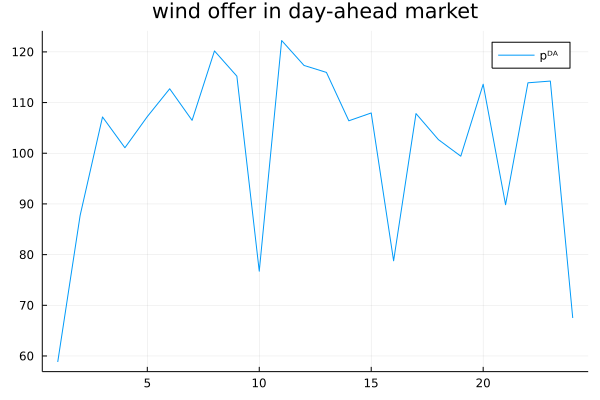

In [17]:
plot(x, value.(pᴰᴬ), title = "wind offer in day-ahead market", label = "pᴰᴬ")

# 2. Variation of the coefficents

While keeping the coefficient for the balancing market price under power excess condition to 0.9, vary the other coefficient from 1.05 to 1.35, and explore how the offerings strategy of the wind farm changes. Similarly, keep coefficient 1.2 unchanged, and vary the other one from 0.75 to 0.95. These results can be illustrated through a couple of figures. A discussion on results is recommended.

## 2.1 Impact of coefficient for the balancing market price under power deficit condition 
Vary the $\gamma_{down}$ coefficient from 1.05 to 1.35 and explore how the offerings strategy of the wind farm changes.

In [62]:
# Input data

γ_up = 0.9 #coefficient for the balancing market price under power excess condition
γ_down = collect(1.05:0.05:1.35) #coefficient for the balancing market price under power defect condition

N_γ_up = length(γ_up) 
N_γ_down = length(γ_down); 

In [64]:
## Resolution 
using JuMP
using GLPK

# Optimization problem
pᴰᴬ_down = zeros(N_t, N_γ_down)

for k = 1:N_γ_down
    OSP_model = Model(GLPK.Optimizer)

    @variable(OSP_model, pᴰᴬ[1:N_t])
    @variable(OSP_model, Δ[1:N_t,1:N_ω])
    @variable(OSP_model, Δ_up[1:N_t,1:N_ω] >= 0)
    @variable(OSP_model, Δ_down[1:N_t,1:N_ω] >= 0)

    @constraint(OSP_model, delta_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== Δ_up[i,j] - Δ_down[i,j])
    @constraint(OSP_model, power_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== pʳᵉᵃˡ[i,j] - pᴰᴬ[i])

    @objective(OSP_model, Max, sum(ℼ[j] * (λᴰᴬ[i,j] * pᴰᴬ[i] + γ_up * λᴰᴬ[i,j] * Δ_up[i,j] - γ_down[k] * λᴰᴬ[i,j] * Δ_down[i,j]) for i in 1:N_t for j in 1:N_ω))

    optimize!(OSP_model)
    
    pᴰᴬ_down[:,k] = value.(pᴰᴬ)
end

## 2.2 Impact of coefficient for the balancing market price under power excess condition 
Vary the coefficient $ \gamma_{up} $from 0.75 to 0.95 and explore how the offerings strategy of the wind farm changes.

In [65]:
# Input data

γ_up = collect(0.75:0.05:0.95) #coefficient for the balancing market price under power excess condition
γ_down = 1.20 #coefficient for the balancing market price under power defect condition

N_γ_up = length(γ_up) 
N_γ_down = length(γ_down); 

In [66]:
## Resolution 
using JuMP
using GLPK

# Optimization problem
pᴰᴬ_up = zeros(N_t, N_γ_up)

for k = 1:N_γ_up
    OSP_model = Model(GLPK.Optimizer)

    @variable(OSP_model, pᴰᴬ[1:N_t])
    @variable(OSP_model, Δ[1:N_t,1:N_ω])
    @variable(OSP_model, Δ_up[1:N_t,1:N_ω] >= 0)
    @variable(OSP_model, Δ_down[1:N_t,1:N_ω] >= 0)

    @constraint(OSP_model, delta_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== Δ_up[i,j] - Δ_down[i,j])
    @constraint(OSP_model, power_con[i=1:N_t,j=1:N_ω], Δ[i,j] .== pʳᵉᵃˡ[i,j] - pᴰᴬ[i])

    @objective(OSP_model, Max, sum(ℼ[j] * (λᴰᴬ[i,j] * pᴰᴬ[i] + γ_up[k] * λᴰᴬ[i,j] * Δ_up[i,j] - γ_down * λᴰᴬ[i,j] * Δ_down[i,j]) for i in 1:N_t for j in 1:N_ω))

    optimize!(OSP_model)
    
    pᴰᴬ_up[:,k] = value.(pᴰᴬ)
end

## 2.3 Results
These results can be illustrated through a couple of figures. A discussion on results is recommended.

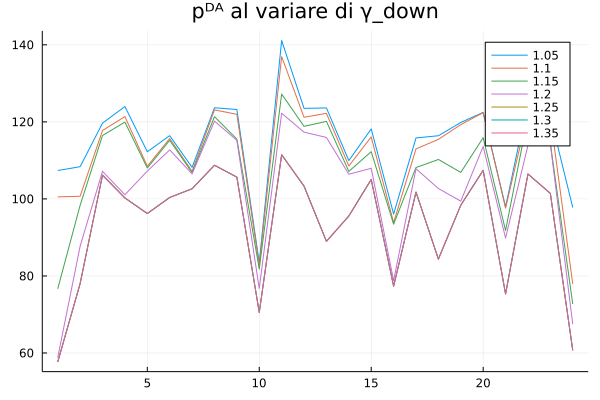

In [80]:
γ_down = collect(1.05:0.05:1.35) 
plot(x, pᴰᴬ_down, title = "pᴰᴬ al variare di γ_down", label = [string.(γ_down[1]) string.(γ_down[2]) string.(γ_down[3]) string.(γ_down[4]) string.(γ_down[5]) string.(γ_down[6]) string.(γ_down[7]) ])

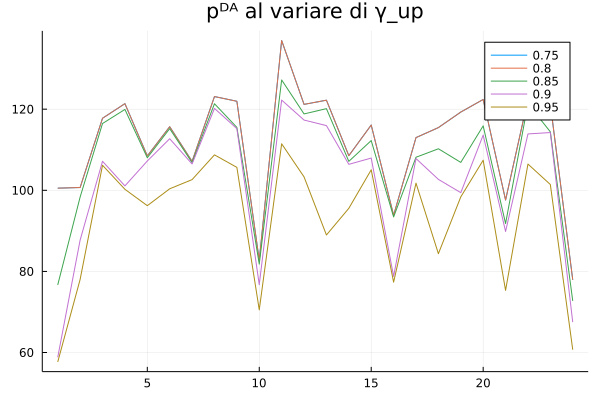

In [81]:
γ_up = collect(0.75:0.05:0.95) 
plot(x, pᴰᴬ_up, title = "pᴰᴬ al variare di γ_up", label = [string.(γ_up[1]) string.(γ_up[2]) string.(γ_up[3]) string.(γ_up[4]) string.(γ_up[5]) ])

# 3. Formulate and solve the riskaverse offering strategy problem

In [68]:
string.(3)

"3"